##### Modelo SEIRS (Susceptibles, Expuestos, Infectados, Recuperados, Susceptibles)

In [1]:
import numpy as np
import scipy
import scipy.integrate

def seirs_model(SEIRS, beta, sigma, gamma, xi, mu):
    S, E, I, R, F = SEIRS
    
    # Poblacion
    N = S + E + I + R
    
    dS = - beta * S * I / N + xi * R
    dE = beta * S * I / N - sigma * E
    dI = sigma * E - gamma * I - mu * I
    dR = gamma * I - xi * R
    dF = mu * I
    
    return [
        dS, dE, dI, dR, dF
    ]

Diferencias en los valores respecto a las razones de cambio:  
    * `beta` es la razon de transmision  
    * `sigma` es la razon de transicion de Expuesto a Infectado  
    * `gamma` es la razon de transicion de Infectado a Recuperado (o aislado)  
    * `xi` es la razon de transicion de Infectado a Susceptible (re-susceptibilidad)
    * `mu` es la razon de transicion de Infectado a Fallecido

In [2]:
def run(SEIRS, days, step=0.1, **kwargs):
    if type(days) is not list:
        days = [days]
    
    final_solution = None
    acc_days = 0
    
    for point_idx, point_days in enumerate(days):
        args = kwargs.copy()
        for key in args:
            if type(args[key]) == list:
                args[key] = args[key][point_idx]
                
        steps = np.arange(start=acc_days, stop=acc_days + point_days, step=step)
        solution = scipy.integrate.solve_ivp(
            lambda _, SEIRS_t: seirs_model(SEIRS_t, **args),
            y0 = SEIRS,
            t_eval = steps,
            t_span = (acc_days, acc_days + point_days)
        )
        
        SEIRS = [_[-1] for _ in solution['y']]
        acc_days = acc_days + point_days
        
        if not final_solution:
            final_solution = solution
        else:
            final_solution['t'] = np.append(final_solution['t'], solution['t'])
            final_solution['y'] = [
                np.append(final_solution['y'][idx], solution_y) for idx, solution_y in enumerate(solution['y'])
            ]
        
    return final_solution

In [3]:
from matplotlib import pyplot

pyplot.rcParams['figure.figsize'] = [50/2.54, 22/2.54]

def plot(x, *curves):
    fig, ax = pyplot.subplots()
    for curve in curves:
        ax.plot(x[:len(curve)], curve)
        
    pyplot.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    
    
import csv

# https://github.com/mauforonda
with open('./data/covid19-bolivia2/nacional.csv') as f:
    csv_file = csv.reader(f)
    data = [[int(_) for _ in line[1:]] for idx, line in enumerate(csv_file) if idx > 0]
    data = zip(*data)
    data = list(data)


In [4]:
R0 = 3.2
periodo_incubacion = 5.2
periodo_infeccioso = 12.4

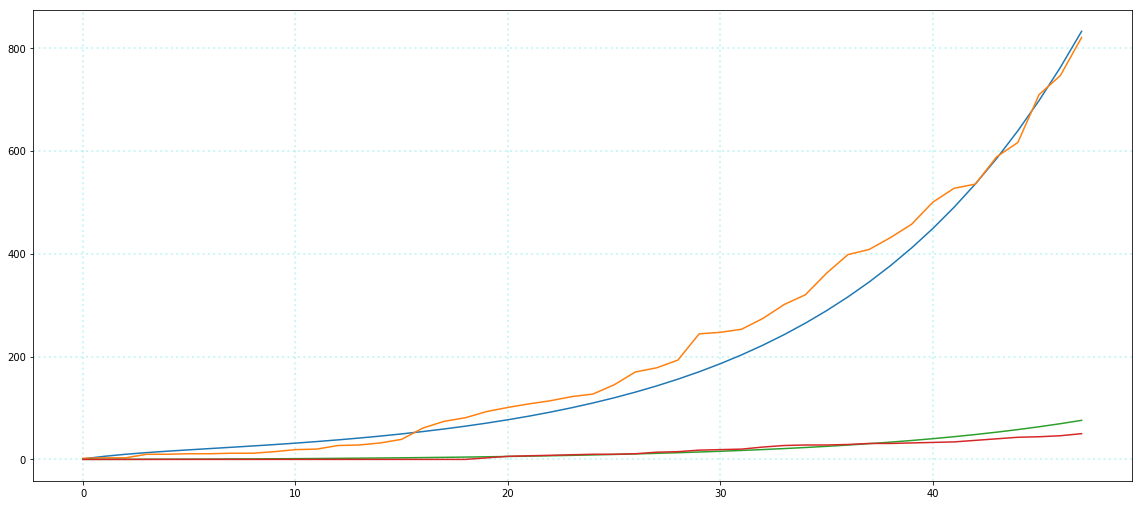

In [5]:
susceptibles_t0 = 11e6
expuestos_t0 = 30
infectados_t0 = 1
dias_simulados = len(data[0])

SEIRS_t0 = (
    susceptibles_t0,
    expuestos_t0,
    infectados_t0,
    0, 0
)
solution = run(
    SEIRS_t0,
    beta = R0 / periodo_infeccioso,
    sigma = 1 / periodo_incubacion,
    gamma = 1 / periodo_infeccioso,
    xi = 0,
    mu = 0.0082, # Estilo aleman
    days = dias_simulados,
    step = 1
)
plot(solution['t'], solution['y'][2], data[0], solution['y'][4], data[2])

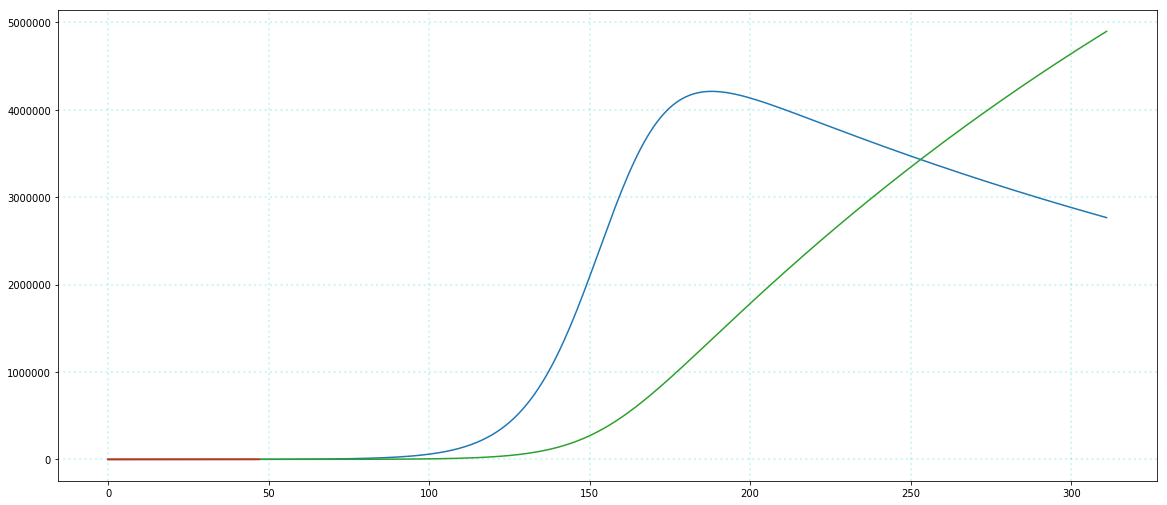

In [6]:
days = [12, 300]
R0_points = [4.2, 3.]

solution = run(
    SEIRS_t0,
    days,
    beta = [R0 / periodo_infeccioso for R0 in R0_points],
    sigma = 1 / periodo_incubacion,
    gamma = 1 / periodo_infeccioso,
    xi = 50,
    mu = 0.0082,
    step = 1
)
plot(solution['t'], solution['y'][2], data[0], solution['y'][4], data[2])

la implementacion funca